In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

from jax.random import PRNGKey, split
from jax import config
config.update("jax_enable_x64", True)
from tqdm import tqdm

from data import generate_data
from loss import create_loss
from network import init_net, compute_end_to_end, compute_factor
from solver import train
from utils import compose, svd, compute_angle, compute_svd_series
from plot import plot_sv_series

In [2]:
key = PRNGKey(0)

input_dim = 30
output_dim = 30
rank = 3
depth = 3
init_type = "orth"
init_scale = 1

key, subkey = split(key)
target = generate_data(key=subkey, shape=(output_dim, input_dim), rank=rank)

key, subkey = split(key)
init_weights = init_net(
    key=subkey, 
    input_dim=input_dim, 
    output_dim=output_dim,
    width=input_dim,
    depth=depth,
    init_scale=init_scale
)

loss_fn = create_loss(target)

loss_fn_dict = {
    'train': loss_fn
}
network_fn = compute_end_to_end

In [3]:
series_list = []

optimizers = ['momentum', 'adam', 'rmsprop']
step_sizes = [1, 1e-2, 1e-2]

for i, optimizer in enumerate(optimizers):
    n_outer_loops = 50
    step_size = step_sizes[i]
    result = train(
        init_weights=init_weights,
        network_fn=network_fn,
        loss_fn_dict=loss_fn_dict,
        n_outer_loops=n_outer_loops,
        step_size=step_size,
        optimizer=optimizer,
        save_weights=True,
        n_inner_loops=1,
    )
    
    layer = 0
    series_list.append(compute_svd_series(result['weights'], layer, rank))

  0%|          | 0/50 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.97it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.38it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.65it/s]


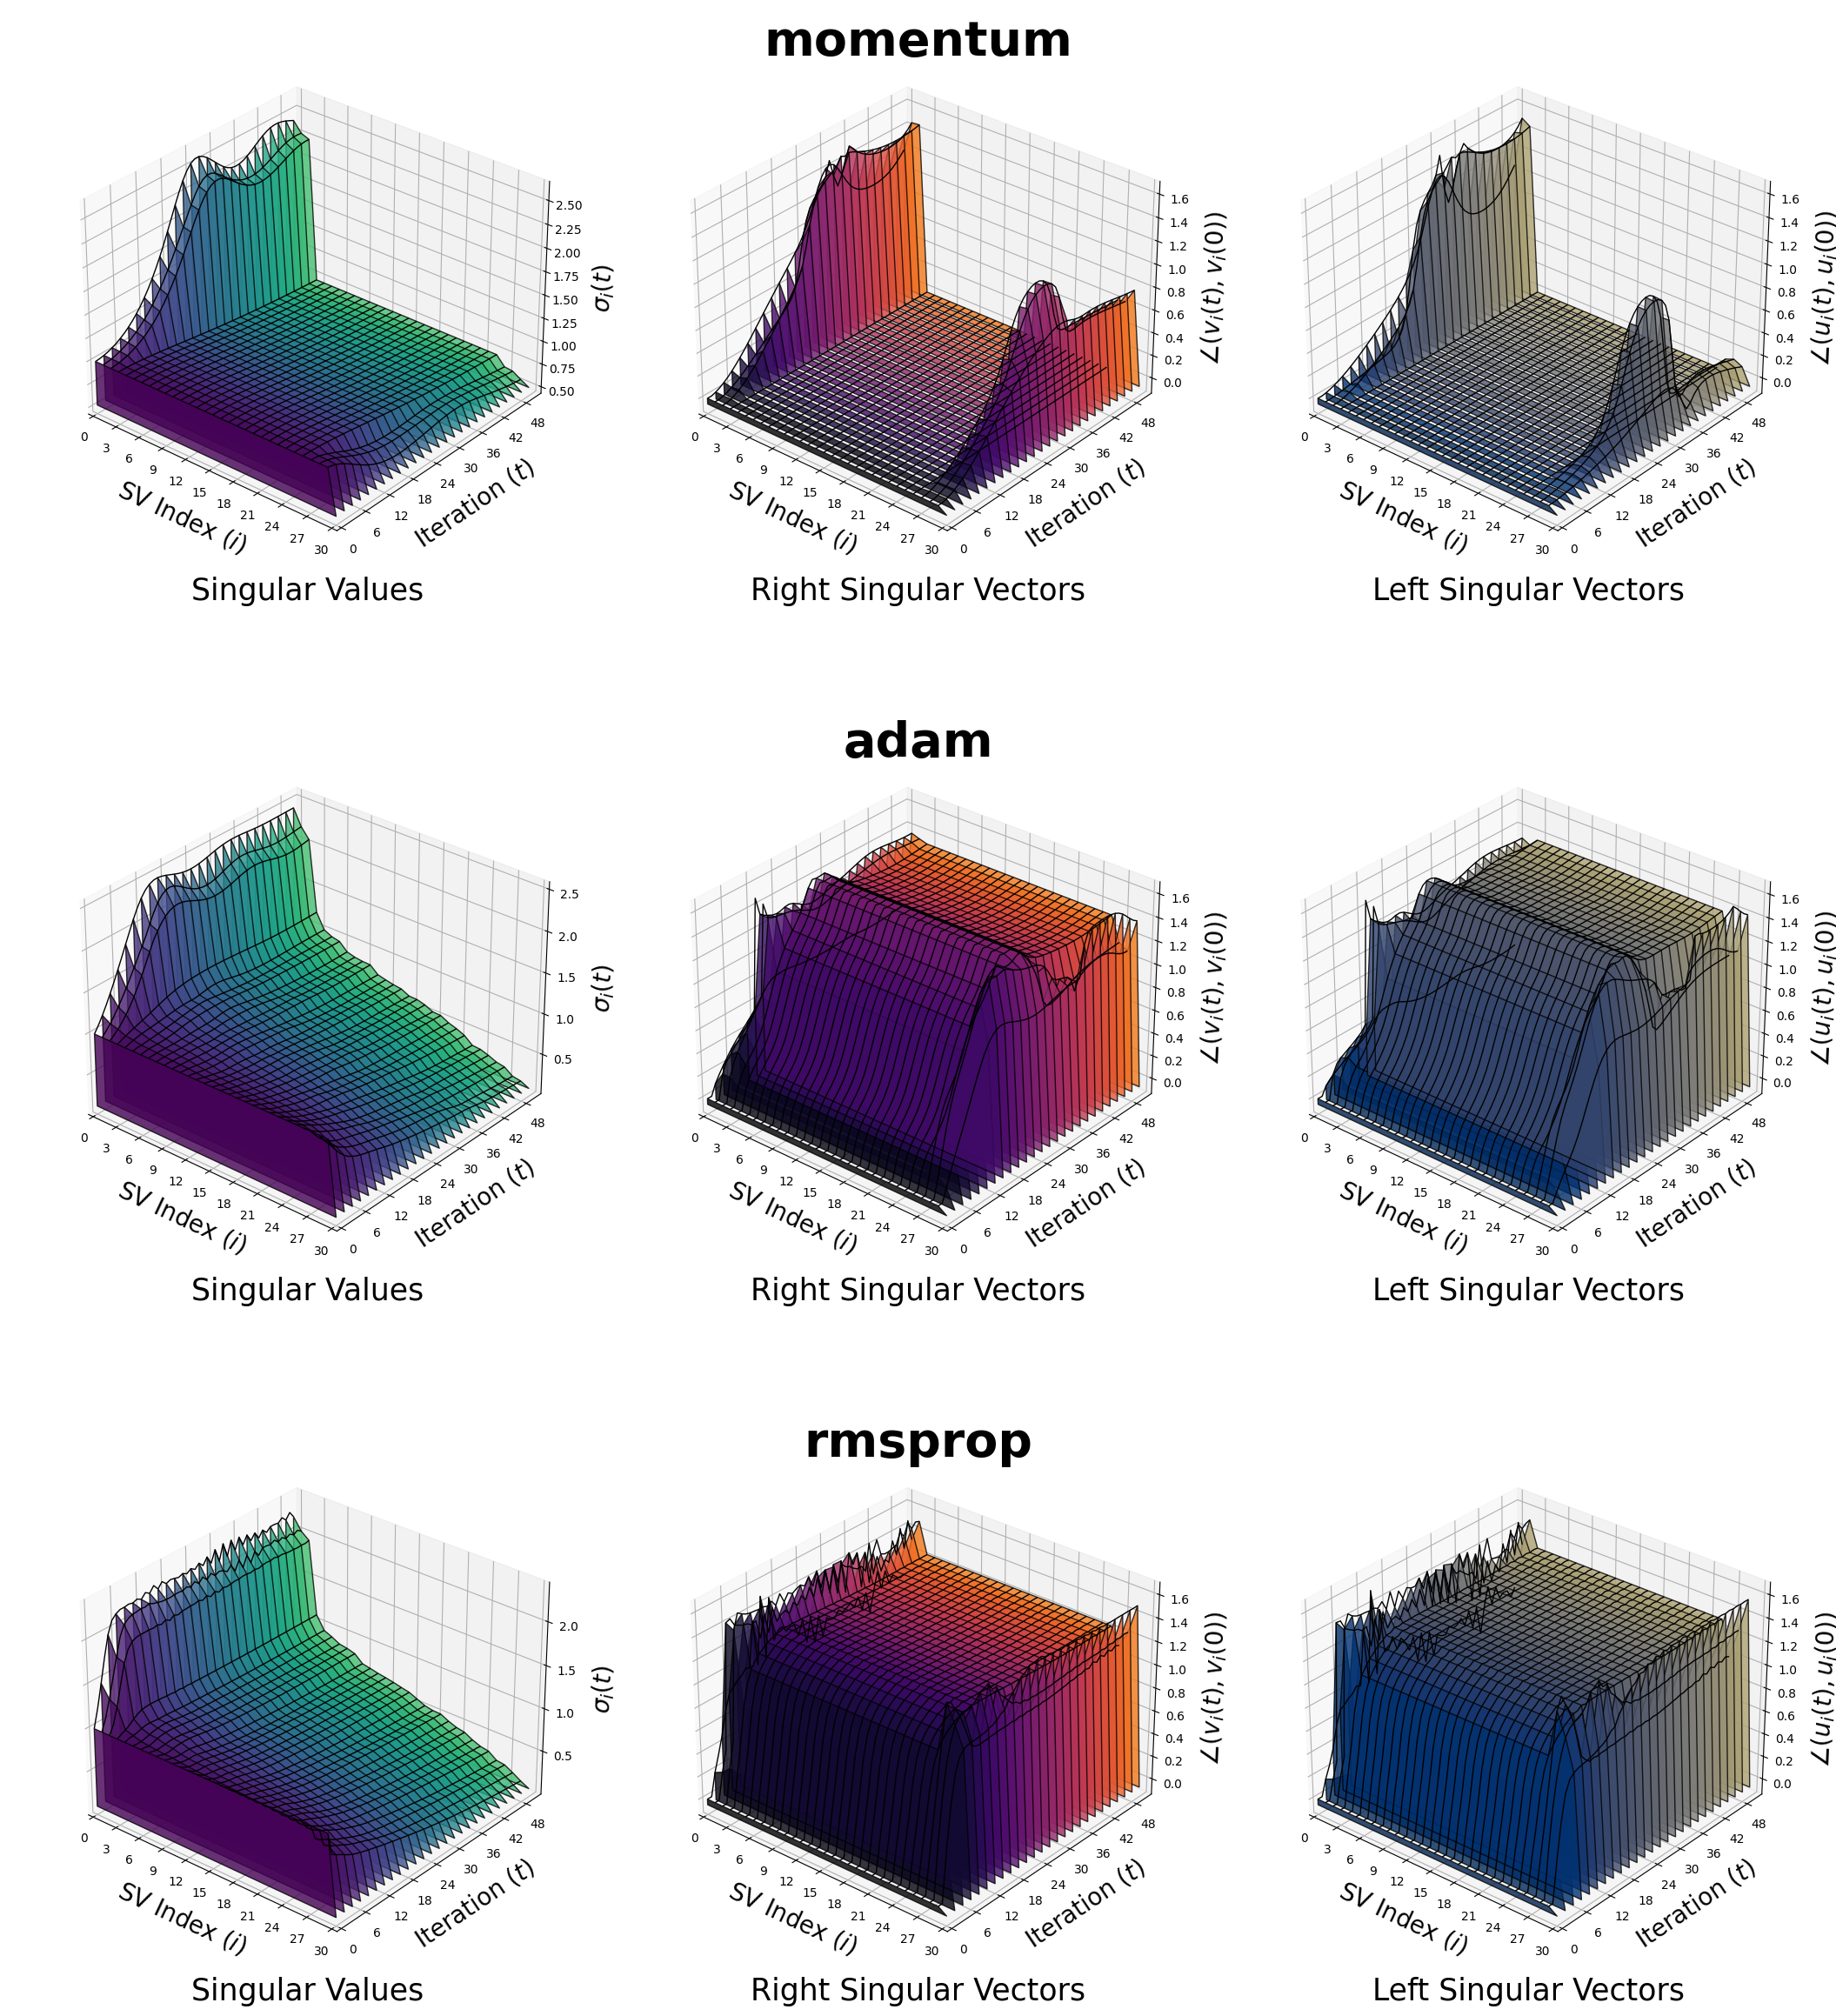

In [6]:
fig = plt.figure(constrained_layout=True, figsize=(21, 24))
subfigs = fig.subfigures(nrows=3, ncols=1)
for i, subfig in enumerate(subfigs):
    sval_series, right_series, left_series = series_list[i]
    subfig.suptitle(f'{optimizers[i]}', fontsize=40, weight='bold', y=0.92)
    ax = subfig.add_subplot(131, projection='3d')
    plot_sv_series(ax, sval_series)

    ax.set_xlabel('\nSV Index ($i$)', fontsize=20)
    ax.set_ylabel('\nIteration ($t$)', fontsize=20)
    ax.set_zlabel('\n$\sigma_i(t)$', fontsize=20)

    ax.set_title('Singular Values', fontsize=25, y=0.0)

    ax = subfig.add_subplot(132, projection='3d')

    plot_sv_series(ax, right_series, color='inferno')

    ax.set_xlabel('\nSV Index ($i$)', fontsize=20)
    ax.set_ylabel('\nIteration ($t$)', fontsize=20)
    ax.set_zlabel('\n' + r'$\angle(v_i(t), v_i(0))$', fontsize=20)

    ax.set_title('Right Singular Vectors', fontsize=25, y=0.0)

    ax = subfig.add_subplot(133, projection='3d')

    plot_sv_series(ax, left_series, color='cividis')

    ax.set_xlabel('\nSV Index ($i$)', fontsize=20)
    ax.set_ylabel('\nIteration ($t$)', fontsize=20)
    ax.set_zlabel('\n' + r'$\angle(u_i(t), u_i(0))$', fontsize=20)

    ax.set_title('Left Singular Vectors', fontsize=25, y=0.0)

plt.savefig('figs/optimizers.png', dpi=300, bbox_inches='tight')

## Only momentum

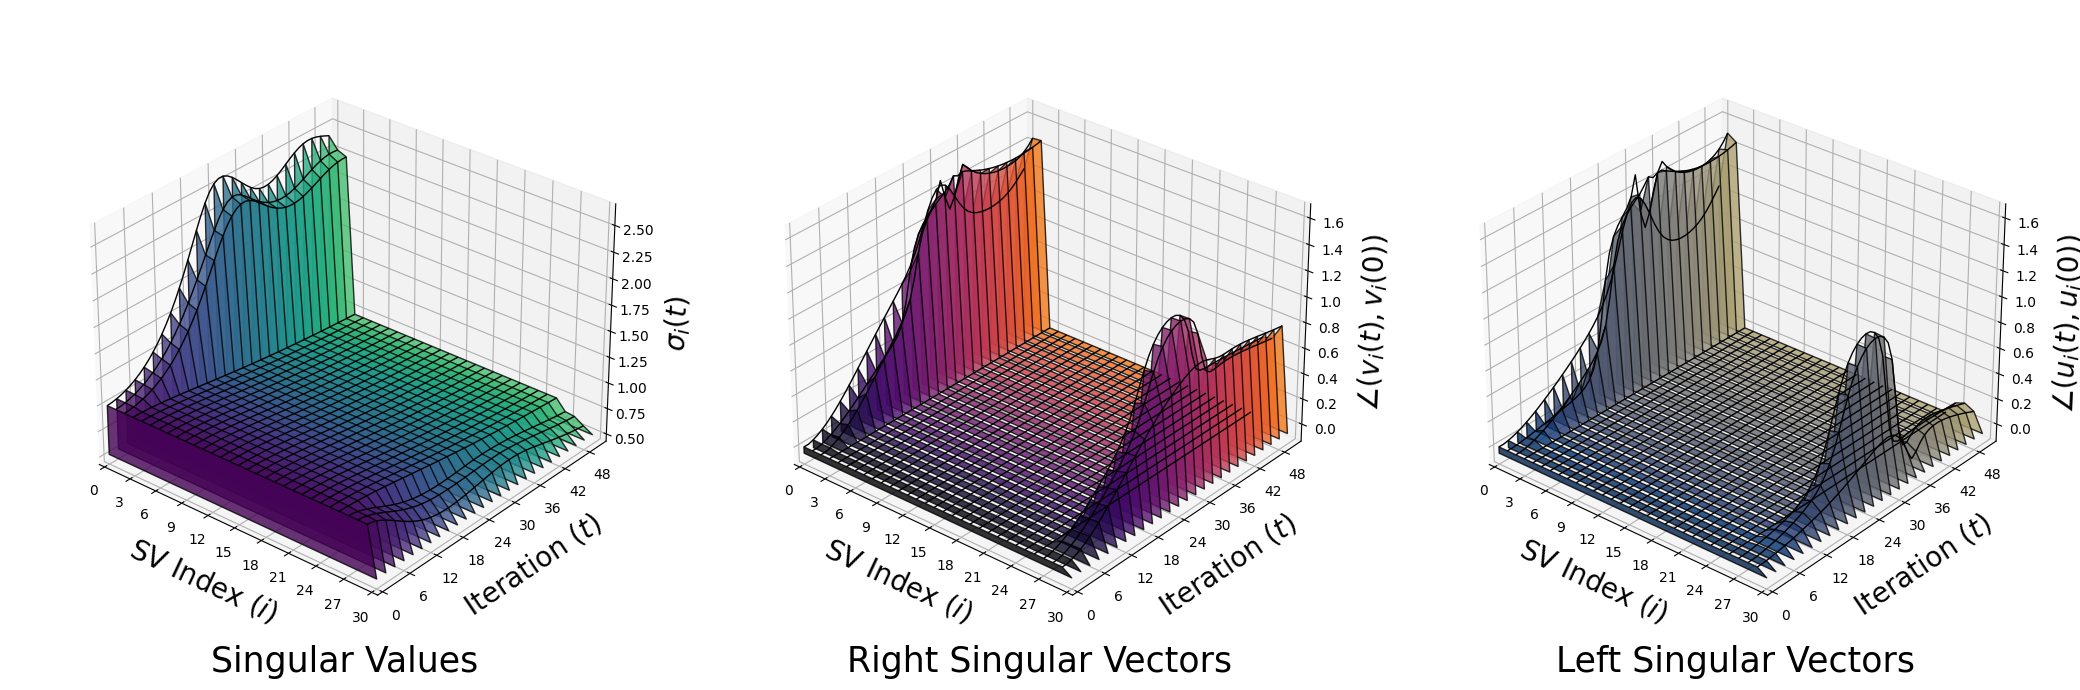

In [5]:
sval_series, right_series, left_series = series_list[0]

fig = plt.figure(figsize=(21, 7))
ax = fig.add_subplot(131, projection='3d')
plot_sv_series(ax, sval_series)

ax.set_xlabel('\nSV Index ($i$)', fontsize=20)
ax.set_ylabel('\nIteration ($t$)', fontsize=20)
ax.set_zlabel('\n$\sigma_i(t)$', fontsize=20)

ax.set_title('Singular Values', fontsize=25, y=0.0)

ax = fig.add_subplot(132, projection='3d')

plot_sv_series(ax, right_series, color='inferno')

ax.set_xlabel('\nSV Index ($i$)', fontsize=20)
ax.set_ylabel('\nIteration ($t$)', fontsize=20)
ax.set_zlabel('\n' + r'$\angle(v_i(t), v_i(0))$', fontsize=20)

ax.set_title('Right Singular Vectors', fontsize=25, y=0.0)

ax = fig.add_subplot(133, projection='3d')

plot_sv_series(ax, left_series, color='cividis')

ax.set_xlabel('\nSV Index ($i$)', fontsize=20)
ax.set_ylabel('\nIteration ($t$)', fontsize=20)
ax.set_zlabel('\n' + r'$\angle(u_i(t), u_i(0))$', fontsize=20)

ax.set_title('Left Singular Vectors', fontsize=25, y=0.0)

plt.tight_layout()
plt.savefig('figs/momentum.png', dpi=300, bbox_inches='tight')